In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [7]:
class KDE:
    
    def __init__(self, data, n=2**14, MIN=None, MAX=None, label=[]):
        self.data = data
        self.n = n
        self.MIN = MIN
        self.MAX = MAX
        self.label = label
        
    # 補助関数
    def _fixed_point(self, t, N, I, a2):
        l = 7
        f = 2*np.pi**(2*l) * sum(I**l*a2*np.exp(-I*np.pi**2*t))
        
        for s in range(l-1, 1, -1):
            Ko = np.prod(range(1, 2*s, 2))/np.sqrt(2*np.pi)
            const = (1+(1/2)**(s+1/2))/3
            time = (2*const*Ko/N/f)**(2/(3+2*s))
            f = 2*np.pi**(2*s)*sum(I**s*a2*np.exp(-I*np.pi**2*time))
            
        return t-(2*N*np.sqrt(np.pi)*f)**(-2/5)
    
    def _dct1d(self, data):
        nrows = len(data)
        weight = 2*(np.exp(-1j*np.array(range(1, nrows))*np.pi/(2*nrows)))
        weight = np.append(1, weight)
        data = np.append(data[::2], data[:0:-2])
        data = (weight*np.fft.fft(data)).real
        
        return data
    
    def _idct1d(self, data):
        nrows = len(data)
        weights = nrows*np.exp(1j*(np.arange(nrows))*np.pi/(2*nrows))
        data = np.real(np.fft.ifft(weights * data))
        output = np.arange(nrows, dtype='d')
        output[::2] = data[0:int(nrows/2)]
        output[1::2] = data[:int(nrows/2)-1:-1]
        
        return output
    
    def fit(self):
        data = np.array(self.data)
        n = int(2**np.ceil(np.log2(self.n)))
        
        if self.MAX == None or self.MIN == None:
            minimum = min(data)
            maximum = max(data)
            Range = maximum - minimum
            
            if self.MAX == None:
                self.MAX = maximum + Range/10
            if self.MIN == None:
                self.MIN = minimum - Range/10
                
        R = self.MAX - self.MIN
        dx = R/(n-1)
        xmesh = np.arange(self.MIN, self.MAX+dx, dx, dtype='d')
        bins = np.append(xmesh, xmesh[-1])
        N = len(np.unique(data))
        
        initial_data = np.histogram(data, bins=bins)[0]/N
        initial_data = initial_data/sum(initial_data)
        
        a = self._dct1d(initial_data)
        
        I = np.arange(1, n, dtype="d")**2
        a2 = (a[1:]/2)**2
        
        t_star = optimize.root(lambda t: self._fixed_point(t, N, I, a2), 0.05)
        if t_star.success == False:
            t_star = 0.28*N**(-2/5)
        else:
            t_star = t_star.x
        a_t = a*np.exp(-np.arange(0, n, dtype="d")**2*np.pi**2*t_star/2)
        
        density = self._idct1d(a_t)/R
        bandswith = np.sqrt(t_star)*R
        
        f = 2*np.pi**2*sum(I*a2*np.exp(-I*np.pi**2*t_star))
        t_cdf = (np.sqrt(np.pi)*f*N)**(-2/3)
        
        a_cdf = a*np.exp(-np.arange(0, n, dtype="d")**2*np.pi**2*t_cdf/2)
        cdf = np.cumsum(self._idct1d(a_cdf))*(dx/R)
        bandswith_cdf = np.sqrt(t_cdf)*R
        
        return bandswith, density, xmesh, cdf
    
    def plot(self, xmesh, density, plot=False):
        if plot == True:
            if self.label:
                plt.plot(xmesh, density, label=self.label)
                plt.legend()
            else:
                plt.plot(xmesh, density)
            plt.ylim(bottom=0)
            

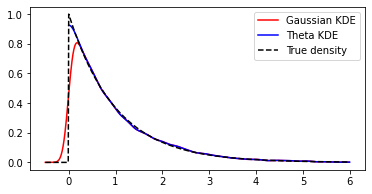

In [8]:
np.random.seed(1234)
h = 0.1
h2 = h**2
c = 1/np.sqrt(2*np.pi)/h
phi = lambda x, x0: np.exp(-(x-x0)**2/(2*h2))
f = lambda x: np.exp(-x)*(x >= 0)
n = 10**4
x = -np.log(np.random.uniform(size=n))
xx = np.arange(-0.5, 6, 0.01, dtype="d")
phis = np.zeros(len(xx))
for i in range(0, n):
    phis = phis + phi(xx, x[i])
phis = c*phis/n

plt.figure(figsize=[6, 3])
plt.plot(xx, phis, 'r')

kde = KDE(x, 2**12, 0, max(x))
bandswith, density, xmesh, cdf = kde.fit()

kde.plot(xmesh, density)

idx = (xmesh <= 6)
plt.plot(xmesh[idx], density[idx], 'b')
plt.plot(xx, f(xx), 'k--')
plt.legend(['Gaussian KDE','Theta KDE', 'True density'])
plt.show()

In [9]:
from scipy.stats import multivariate_normal

In [10]:
Xmat = np.genfromtxt('../../csv/clusterdata.csv', delimiter=',')
K = 3
n, D = Xmat.shape

W = np.array([[1/3,1/3,1/3]])
M  = np.array([[-2.0,-4,0],[-3,1,-1]])
C = np.zeros((3,2,2))

C[:,0,0] = 1
C[:,1,1] = 1

p = np.zeros((3, 300))

for i in range(0, 100):
    for k in range(0, K):
        mvn = multivariate_normal(M[:,k].T, C[k,:,:])
        p[k,:] = W[0,k]*mvn.pdf(Xmat)
        
    p = p/sum(p, 0)
    
    W = np.mean(p, 1).reshape(1, 3)
    for k in range(0, K):
        M[:,k] = (Xmat.T @ p[k,:].T)/sum(p[k,:])
        xm = Xmat.T - M[:,k].reshape(2, 1)
        C[k,:,:] = xm @ (xm*p[k,:]).T/sum(p[k,:])
        
print(W)

[[0.33033004 0.32063338 0.34903658]]
